# ResNet plus developments

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline

See MIT License in https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 Online.


In [92]:
#!/usr/bin/env python3

import os
from pathlib import Path
import time
from datetime import datetime
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

np.random.seed(999123)

# User inputs

In [93]:
flist = ['private_dog2'] # List of dataset directory names. WormsTwoClass Lightning2 Earthquakes GunPoint 
batch_size = 64 
nb_epochs = 500
model_type = 'MLP'
k = 1 # For k-fold cross validation. If k=1, the original test-train split is used.
m = 10 # Number of repetitions of k-fold cross validation (if k>1).
early_stopping = False 
tensorboard = True # Set to True to write logs for use by TensorBoard
k_fold_seed = 765432

# Output directories
logs_dir = '../logs'
tensorboard_dir = '../logs/tensorboard'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp
tensorboard_dir = tensorboard_dir +'/' + timestamp

# Input directory
if 'private' in flist[0]:
    fdir = '../data/private_data/private_events_dev' 
else:
    fdir = '../data' 

# Tools

In [94]:
def plot_confusion_matrix(cm, title='Normalised confusion matrix', save=False):
    ''' Plot the normalised confusion matrix
    Parameters
    cm : array - normalised confusion matrix
    Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
    'Confusion Matrix' https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    '''
    classes = ['Positive', 'Negative']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.clim(0, 1)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    if save:
        plt.savefig('cm_devnet.png', bbox_inches='tight')
        
        
def plot_roc(y_true, y_probs, save=False): 
    ''' Plot ROC and return AUC
    Parameters
    y_true : vector of true class labels.
    y_probs : array of predicted probabilities, one column for each class.
    Returns
    auc : float
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_probs[:,1])
    auc = roc_auc_score(y_true, y_probs[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    if save:
        plt.savefig('roc_devnet.png', bbox_inches='tight')
    return auc


def readucr(filename):
    ''' Load a dataset from a file in UCR format
    space delimited, class labels in the first column.
    Returns
    X : DNN input data
    Y : class labels
    '''
    data = np.loadtxt(Path(filename))
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
   

# Build DNN
## ResNet

In [95]:
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
         
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)   
    out = Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out

## MLP

In [96]:
def build_mlp(input_shape, nb_classes):
    x = Input(shape=(input_shape))
    y = Dense(128, activation='relu', name='Dense010')(x)
    y = Dense(128, activation='relu', name='Dense020')(y)
    out = Dense(nb_classes, activation='sigmoid', name='Dense040')(y)
    return x, out 

# Train model

In [97]:
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes = len(np.unique(y_test))
     
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
     
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std) 
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    if model_type == 'MLP':
        x, y = build_mlp(x_train.shape[1:], nb_classes)
    else:
        x_train = x_train.reshape(x_train.shape + (1,1,))
        x_test = x_test.reshape(x_test.shape + (1,1,))
        x, y = build_resnet(x_train.shape[1:], 64, nb_classes)
    model = Model(x, y)
    #print(model.summary())
    
    optimizer = keras.optimizers.RMSprop()#.Adam()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    
    Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                      patience=50, min_lr=0.0001) 
    callbacks = [reduce_lr]
    if tensorboard:
        tb_dir = tensorboard_dir+'/'+fname+'_'+label
        Path(tb_dir).mkdir(parents=True, exist_ok=True) 
        print('Tensorboard logs in', tb_dir)
        callbacks.append(keras.callbacks.TensorBoard(log_dir=tb_dir, histogram_freq=0))

    if early_stopping:
        early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', baseline=0.6, min_delta=0.001, 
         patience=100, verbose=1) # when tf updates keras, use restore_best_weights instead of ModelCheckPoint
        # save_best_only - we are interested in only the very best model observed during training, 
        # rather than the best compared to the previous epoch, which might not be the best overall 
        # if training is noisy
        model_save = keras.callbacks.ModelCheckpoint(logs_dir+'/temp.h5', monitor='val_acc', 
            save_best_only=True, save_weights_only=True, verbose=1) #
        callbacks.append(early_stop)
        callbacks.append(model_save)
  
    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=1, validation_data=(x_test, Y_test), callbacks=callbacks)
    end = time.time()
    log = pd.DataFrame(hist.history) 
    
    # Print results
    duration_seconds = round(end-start)
    duration_minutes = str(round((end-start)/60))
    print('Training complete on', fname, 'Duration:', duration_seconds, 'secs; about', duration_minutes, 'minutes.')
    
    if not early_stopping:
        # Print and save results. Print the testing results which has the lowest training loss.
        print('Selected the test result with the lowest training loss. Loss and validation accuracy are -')
        idx = log['loss'].idxmin()
        loss = log.loc[idx]['loss']
        val_acc = log.loc[idx]['val_acc']
        epoch = idx + 1
        print(loss, val_acc, 'at index', str(idx), ' (epoch ', str(epoch), ')')
    else:
        print('Early stopping.')
        model.load_weights(logs_dir+'/temp.h5')
        eval = model.evaluate(x_train, Y_train)
        print('From model.evaluate() on training set', model.metrics_names)
        print(eval)
        eval = model.evaluate(x_test, Y_test)
        print('From model.evaluate()', model.metrics_names)
        print(eval)
        loss = eval[0] # val_loss
        val_acc = eval[1]
        epoch = early_stop.stopped_epoch
        print('stop_epoch:', epoch)
        idx = epoch - 1
        logged_loss = log.loc[idx]['loss']
        logged_val_acc = log.loc[idx]['val_acc']
        print('logged loss and val_acc', logged_loss, logged_val_acc)
        
        
    summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+str(epoch)+' |'+ duration_minutes + 'mins  |'
    summary_csv = label+','+str(loss)+','+str(val_acc)+','+str(epoch)+','+ duration_minutes 
    
    # Save summary file and log file.
    print('Tensorboard logs in', tb_dir)
    with open(logs_dir+'/'+fname+'/devnet_summary.csv', 'a+') as f:
        f.write(summary_csv)
        f.write('\n')
        print('Added summary row to ', logs_dir+'/'+fname+'/devnet_summary.csv')  
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    
    return summary, model

# Train DNN

In [98]:
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = RepeatedKFold(n_splits=k, n_repeats=m, random_state=k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary, model = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary, model = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
print(fname, timestamp)
print('train:test', y_train.shape[0], y_test.shape[0])
for each in results:
    print(each)

Running dataset private_dog2
Tensorboard logs in ../logs/tensorboard/2019-03-09T09:33/private_dog2_0
Train on 120 samples, validate on 40 samples
Epoch 1/500
120/120 [==============================] - 0s 2ms/step - loss: 0.8888 - acc: 0.4458 - val_loss: 0.8923 - val_acc: 0.6000
Epoch 2/500
120/120 [==============================] - 0s 107us/step - loss: 0.7384 - acc: 0.6083 - val_loss: 0.7033 - val_acc: 0.6375
Epoch 3/500
120/120 [==============================] - 0s 118us/step - loss: 0.5632 - acc: 0.7083 - val_loss: 0.7632 - val_acc: 0.6125
Epoch 4/500
120/120 [==============================] - 0s 136us/step - loss: 0.5483 - acc: 0.7083 - val_loss: 0.7482 - val_acc: 0.6250
Epoch 5/500
120/120 [==============================] - 0s 144us/step - loss: 0.5170 - acc: 0.7208 - val_loss: 0.8352 - val_acc: 0.5250
Epoch 6/500
120/120 [==============================] - 0s 151us/step - loss: 0.5198 - acc: 0.7375 - val_loss: 0.7996 - val_acc: 0.6000
Epoch 7/500
120/120 [=========================

120/120 [==============================] - 0s 166us/step - loss: 0.2522 - acc: 0.9000 - val_loss: 1.5483 - val_acc: 0.6000
Epoch 61/500
120/120 [==============================] - 0s 157us/step - loss: 0.4249 - acc: 0.7792 - val_loss: 1.6409 - val_acc: 0.5875
Epoch 62/500
120/120 [==============================] - 0s 150us/step - loss: 0.3537 - acc: 0.8167 - val_loss: 1.6542 - val_acc: 0.5750
Epoch 63/500
120/120 [==============================] - 0s 154us/step - loss: 0.2899 - acc: 0.8917 - val_loss: 1.5613 - val_acc: 0.5500
Epoch 64/500
120/120 [==============================] - 0s 154us/step - loss: 0.2638 - acc: 0.8958 - val_loss: 1.5033 - val_acc: 0.5500
Epoch 65/500
120/120 [==============================] - 0s 157us/step - loss: 0.2604 - acc: 0.8750 - val_loss: 1.5074 - val_acc: 0.5500
Epoch 66/500
120/120 [==============================] - 0s 159us/step - loss: 0.2773 - acc: 0.8667 - val_loss: 1.5780 - val_acc: 0.5750
Epoch 67/500
120/120 [==============================] - 0s 16

120/120 [==============================] - 0s 142us/step - loss: 0.2202 - acc: 0.8958 - val_loss: 1.9111 - val_acc: 0.5625
Epoch 121/500
120/120 [==============================] - 0s 149us/step - loss: 0.2117 - acc: 0.9125 - val_loss: 2.0488 - val_acc: 0.6000
Epoch 122/500
120/120 [==============================] - 0s 178us/step - loss: 0.1814 - acc: 0.9292 - val_loss: 2.0296 - val_acc: 0.6000
Epoch 123/500
120/120 [==============================] - 0s 183us/step - loss: 0.1759 - acc: 0.9208 - val_loss: 2.0388 - val_acc: 0.5125
Epoch 124/500
120/120 [==============================] - 0s 172us/step - loss: 0.2192 - acc: 0.8833 - val_loss: 2.1551 - val_acc: 0.5500
Epoch 125/500
120/120 [==============================] - 0s 127us/step - loss: 0.1766 - acc: 0.9208 - val_loss: 1.9812 - val_acc: 0.5750
Epoch 126/500
120/120 [==============================] - 0s 136us/step - loss: 0.2040 - acc: 0.9167 - val_loss: 1.8890 - val_acc: 0.5500
Epoch 127/500
120/120 [==============================] 

Epoch 180/500
120/120 [==============================] - 0s 160us/step - loss: 0.1373 - acc: 0.9500 - val_loss: 2.3007 - val_acc: 0.5500
Epoch 181/500
120/120 [==============================] - 0s 137us/step - loss: 0.1275 - acc: 0.9375 - val_loss: 2.3995 - val_acc: 0.5500
Epoch 182/500
120/120 [==============================] - 0s 155us/step - loss: 0.1790 - acc: 0.9125 - val_loss: 2.3623 - val_acc: 0.5875
Epoch 183/500
120/120 [==============================] - 0s 141us/step - loss: 0.1475 - acc: 0.9458 - val_loss: 2.3218 - val_acc: 0.5500
Epoch 184/500
120/120 [==============================] - 0s 136us/step - loss: 0.1575 - acc: 0.9292 - val_loss: 2.2671 - val_acc: 0.5750
Epoch 185/500
120/120 [==============================] - 0s 166us/step - loss: 0.1205 - acc: 0.9667 - val_loss: 2.3344 - val_acc: 0.5500
Epoch 186/500
120/120 [==============================] - 0s 156us/step - loss: 0.1222 - acc: 0.9500 - val_loss: 2.3846 - val_acc: 0.5500
Epoch 187/500
120/120 [==================

Epoch 240/500
120/120 [==============================] - 0s 168us/step - loss: 0.1037 - acc: 0.9583 - val_loss: 2.6874 - val_acc: 0.5375
Epoch 241/500
120/120 [==============================] - 0s 174us/step - loss: 0.1445 - acc: 0.9292 - val_loss: 2.4785 - val_acc: 0.5625
Epoch 242/500
120/120 [==============================] - 0s 166us/step - loss: 0.0846 - acc: 0.9583 - val_loss: 2.4936 - val_acc: 0.5750
Epoch 243/500
120/120 [==============================] - 0s 168us/step - loss: 0.1181 - acc: 0.9417 - val_loss: 2.5095 - val_acc: 0.5750
Epoch 244/500
120/120 [==============================] - 0s 164us/step - loss: 0.0995 - acc: 0.9708 - val_loss: 2.6449 - val_acc: 0.5750
Epoch 245/500
120/120 [==============================] - 0s 171us/step - loss: 0.1599 - acc: 0.9000 - val_loss: 2.5806 - val_acc: 0.5750
Epoch 246/500
120/120 [==============================] - 0s 177us/step - loss: 0.1681 - acc: 0.9167 - val_loss: 2.4394 - val_acc: 0.6000
Epoch 247/500
120/120 [==================

Epoch 300/500
120/120 [==============================] - 0s 160us/step - loss: 0.0482 - acc: 0.9875 - val_loss: 3.0794 - val_acc: 0.5625
Epoch 301/500
120/120 [==============================] - 0s 156us/step - loss: 0.0694 - acc: 0.9750 - val_loss: 3.1126 - val_acc: 0.5500
Epoch 302/500
120/120 [==============================] - 0s 161us/step - loss: 0.0726 - acc: 0.9833 - val_loss: 2.9141 - val_acc: 0.5750
Epoch 303/500
120/120 [==============================] - 0s 167us/step - loss: 0.0858 - acc: 0.9667 - val_loss: 3.2044 - val_acc: 0.5750
Epoch 304/500
120/120 [==============================] - 0s 169us/step - loss: 0.2028 - acc: 0.9083 - val_loss: 3.0196 - val_acc: 0.5250
Epoch 305/500
120/120 [==============================] - 0s 162us/step - loss: 0.0965 - acc: 0.9625 - val_loss: 2.9362 - val_acc: 0.5750
Epoch 306/500
120/120 [==============================] - 0s 168us/step - loss: 0.0790 - acc: 0.9667 - val_loss: 2.7628 - val_acc: 0.5750
Epoch 307/500
120/120 [==================

Epoch 360/500
120/120 [==============================] - 0s 157us/step - loss: 0.4501 - acc: 0.8875 - val_loss: 3.7172 - val_acc: 0.5625
Epoch 361/500
120/120 [==============================] - 0s 152us/step - loss: 0.4487 - acc: 0.9250 - val_loss: 3.2390 - val_acc: 0.5750
Epoch 362/500
120/120 [==============================] - 0s 163us/step - loss: 0.3111 - acc: 0.9708 - val_loss: 3.2039 - val_acc: 0.5625
Epoch 363/500
120/120 [==============================] - 0s 162us/step - loss: 0.2906 - acc: 0.9833 - val_loss: 3.2295 - val_acc: 0.5625
Epoch 364/500
120/120 [==============================] - 0s 198us/step - loss: 0.2882 - acc: 0.9833 - val_loss: 3.2565 - val_acc: 0.5750
Epoch 365/500
120/120 [==============================] - 0s 191us/step - loss: 0.2873 - acc: 0.9833 - val_loss: 3.2728 - val_acc: 0.5625
Epoch 366/500
120/120 [==============================] - 0s 196us/step - loss: 0.2881 - acc: 0.9833 - val_loss: 3.1592 - val_acc: 0.5750
Epoch 367/500
120/120 [==================

Epoch 420/500
120/120 [==============================] - 0s 159us/step - loss: 0.2789 - acc: 0.9833 - val_loss: 3.6022 - val_acc: 0.5500
Epoch 421/500
120/120 [==============================] - 0s 157us/step - loss: 0.2771 - acc: 0.9833 - val_loss: 3.6371 - val_acc: 0.5500
Epoch 422/500
120/120 [==============================] - 0s 163us/step - loss: 0.2751 - acc: 0.9833 - val_loss: 3.6354 - val_acc: 0.5500
Epoch 423/500
120/120 [==============================] - 0s 161us/step - loss: 0.2739 - acc: 0.9833 - val_loss: 3.6382 - val_acc: 0.5500
Epoch 424/500
120/120 [==============================] - 0s 154us/step - loss: 0.2744 - acc: 0.9833 - val_loss: 3.6620 - val_acc: 0.5625
Epoch 425/500
120/120 [==============================] - 0s 157us/step - loss: 0.2747 - acc: 0.9833 - val_loss: 3.6651 - val_acc: 0.5750
Epoch 426/500
120/120 [==============================] - 0s 165us/step - loss: 0.2750 - acc: 0.9833 - val_loss: 3.7833 - val_acc: 0.5500
Epoch 427/500
120/120 [==================

Epoch 480/500
120/120 [==============================] - 0s 169us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 3.5128 - val_acc: 0.5750
Epoch 481/500
120/120 [==============================] - 0s 153us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 3.5086 - val_acc: 0.5750
Epoch 482/500
120/120 [==============================] - 0s 152us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 3.5293 - val_acc: 0.5750
Epoch 483/500
120/120 [==============================] - 0s 170us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 3.5455 - val_acc: 0.5750
Epoch 484/500
120/120 [==============================] - 0s 159us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 3.6131 - val_acc: 0.5625
Epoch 485/500
120/120 [==============================] - 0s 165us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 3.6053 - val_acc: 0.5625
Epoch 486/500
120/120 [==============================] - 0s 160us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 3.6024 - val_acc: 0.5625
Epoch 487/500
120/120 [==================

In [99]:
# Print when done
print('Done at:' , '{:%Y-%m-%dT%H:%M}'.format(datetime.now()))

Done at: 2019-03-09T09:34


# Metrics

Predicted class probabilities:
 [[9.9999070e-01 2.7888302e-06]
 [8.3129351e-08 9.9999988e-01]
 [9.5110756e-01 4.9663812e-02]
 [9.9389738e-01 1.2116169e-02]
 [3.1827353e-02 9.2261881e-01]]
Pred [0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1]
True [1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1]
[[12  8]
 [ 9 11]]
Calculated accuracy: 0.575
Normalised confusion matrix:
 [[0.6  0.4 ]
 [0.45 0.55]]


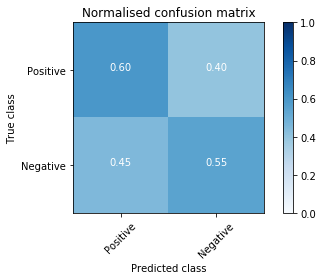

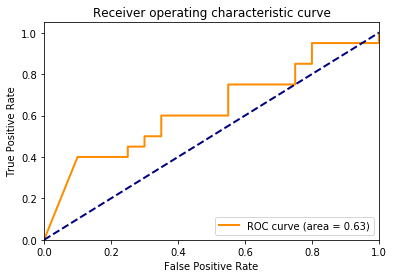

AUC: 0.6299999999999999

               precision    recall  f1-score   support

         0.0       0.58      0.55      0.56        20
         1.0       0.57      0.60      0.59        20

   micro avg       0.57      0.57      0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40


micro av - averaging the total true positives, false negatives and false positives
macro av - averaging the unweighted mean per label
weighted av - averaging the support-weighted mean per label


In [100]:
# Use trained model (after all epochs) to make predictions
do_print = True
x_input = x_test
y_input = y_test
y_input = y_input - y_input.min()
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_input = (x_input - x_train_mean)/(x_train_std)
if model_type != 'MLP':
    x_input = x_input.reshape(x_input.shape + (1,1,))
nb_classes = len(np.unique(y_input))
y_input = (y_input - y_input.min())/(y_input.max()-y_input.min())*(nb_classes-1)
# Calculate model prediction
y_probs = model.predict_on_batch(x_input)
y_class = y_probs.argmax(axis=1)
cm = confusion_matrix(y_input, y_probs.argmax(axis=1), labels=[1,0])
acc_calc = (cm[0][0]+cm[1][1])/(cm.sum())
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
if do_print:
    print('Predicted class probabilities:\n', y_probs[:5,:])
    print('Pred', y_class[:20])
    print('True', y_input[:20].astype(int))
    print(cm)
    print('Calculated accuracy:',acc_calc) 
    print('Normalised confusion matrix:\n', cm_norm)
title = 'Normalised confusion matrix'
plot_confusion_matrix(cm_norm, title=title, save=True)

# ROC and AUC
auc = plot_roc(y_input, y_probs)
print('AUC:', auc)

report = classification_report(y_input, y_class)
print('\n', report)
print('\nmicro av - averaging the total true positives, false negatives and false positives')
print('macro av - averaging the unweighted mean per label')
print('weighted av - averaging the support-weighted mean per label')